# **SIADS Milestone II - Forecasting Federal Funds Rate Movements through Natural Language Processing of FOMC Minutes**

**s24-milestone2-team7-cspaarg-cydia-davidrez**
- **Casey Spaargaren(cspaarg@umich.edu)**, School of Information, University of Michigan
- **Cydia Tsang (cydia@umich.edu)**, School of Information, University of Michigan
- **David Rezkalla(davidrez@umich.edu)**, School of Information, University of Michigan


#### **Strcuture of the Code:**

&emsp; **Data Import**<br>
&emsp;&emsp;&emsp; Federal Reserve's meeting minutes from 2000 to 2024<br>
&emsp; **Data Cleaning & Manipulation**<br>
&emsp; **Basic Descriptive Statistic**<br>
&emsp;&emsp;&emsp; 1. Basic Desciptive Statistic Analysis<br>
&emsp; **Supervising Learning**<br>
&emsp;&emsp;&emsp; 1. Naive Bayes, Linear Regression, Support Vector Machine (SVM), and Decision Trees<br>
&emsp;&emsp;&emsp; 2. Random Forest<br>
&emsp;&emsp;&emsp; 3. Random Forest<br>
&emsp;&emsp;&emsp; 4. LSTM (Long Short-Term Memory) Networks:<br>
&emsp;&emsp;&emsp; 5. LLM Model: Bert/ Llama<br>
&emsp; **Unsupervising Learning**<br>
&emsp;&emsp;&emsp; 1. Topic Modeling (e.g., Latent Dirichlet Allocation - LDA)<br>
&emsp;&emsp;&emsp; 2. Clustering (e.g., K-Means)<br>
&emsp;&emsp;&emsp; 3. Semantic Analysis<br>
&emsp;&emsp;&emsp; 4. LSTM (Long Short-Term Memory) Networks:<br>
&emsp;&emsp;&emsp; 5. Principal Component Analysis (PCA)<br>

In [3]:
#Remeber to run the following commannd before running the following codes. Details Please refer to README.md
!pip install -r requirements.txt

In [4]:
from bs4 import BeautifulSoup
import urllib
from time import sleep
import re,csv,os
from os import listdir
from os.path import isfile, join
import os
import glob
import nltk
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **Data Import**

The project requires the Federal Reserve's meeting minutes from 2000 to 2024, sourced from the official Fed website at https://www.federalreserve.gov. The Federal Open Market Committee (FOMC) holds eight regularly scheduled meetings each year, with additional meetings as needed. Policy statements and minutes are linked in the calendars on the website. The minutes of regularly scheduled meetings are released three weeks after the policy decision date, and committee membership changes occur at the first meeting of each year. The retrieved data is organized and stored as individual files, named meeting_minute_YYYYMMDD.txt, in the data/output directory.

In [5]:
releaseDates = [line.rstrip() for line in open(os.path.join('data/meeting_minute/meeting_dates.csv'), 'r')]

def getFedMeetingMinutesUrl(date):
    year = date[0:4]
    dateInt = int(date)
    if dateInt <= 19951219:
        url = 'https://www.federalreserve.gov/fomc/MINUTES/' + year + '/' + date + 'min.htm'
    elif dateInt >= 19950201 and dateInt < 20070918:
        url = 'https://www.federalreserve.gov/fomc/minutes/' + date + '.htm'
    elif dateInt == 20080625:
        url = 'https://www.federalreserve.gov/monetarypolicy/fomc20080625.htm'
    elif dateInt > 20070918:
        url = 'https://www.federalreserve.gov/monetarypolicy/fomcminutes' + date + '.htm'
    print(url)
    return url

def getStatement(date):
    print('Pulling meeting minute of date: ' + date)
    req = urllib.request.Request(getFedMeetingMinutesUrl(date), headers={'User-Agent' : "Magic Browser"}) 
    html = urllib.request.urlopen( req ).read()
    soup = BeautifulSoup(html)
    minutesText = soup.get_text(" ")
    return minutesText

In [6]:
for releaseDate in releaseDates:
    file_path="./data/output/meeting_minute_" + releaseDate +".txt"
    if os.path.isfile(file_path) == False:
        data = getStatement(releaseDate)
        sleep(2)
    
        f = open(file_path, 'w')
        f.write(data)
        f.close

# **Data Cleaning & Manipulation***

In [7]:
# Load FOMC meeting minutes
meeting_minutes_dir = "data/output"
meeting_minutes_files = os.listdir(meeting_minutes_dir)

# Function to preprocess text (tokenize and remove stop words)
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

meeting_minutes = []
for file in meeting_minutes_files:
    file_path = os.path.join(meeting_minutes_dir, file)
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
    except UnicodeDecodeError:
        try:
            with open(file_path, 'r', encoding='latin-1') as f:
                text = f.read()
        except UnicodeDecodeError as e:
            print(f"Error reading {file}: {e}")
            continue

    preprocessed_text = preprocess_text(text)
    meeting_minute = {
        'meeting_minute': preprocessed_text,
        'file_date': file.replace('meeting_minute_', '').replace('.txt', '')
    }
    meeting_minutes.append(meeting_minute)

In [8]:
meeting_minutes_df = pd.DataFrame(meeting_minutes)
meeting_minutes_df.file_date = pd.to_datetime(meeting_minutes_df.file_date, format='%Y%m%d')
meeting_minutes_df = meeting_minutes_df.set_index('file_date')
meeting_minutes_df = meeting_minutes_df.sort_index()
meeting_minutes_df.head()

,meeting_minute
file_date,
1993-02-03,frb fomc minutesfebruary 23 1993 minutes feder...
1993-03-23,frb fomc minutesmarch 23 1993 minutes federal ...
1993-05-18,frb fomc minutesmay 18 1993 minutes federal op...
1993-07-07,frb fomc minutesjuly 67 1993 minutes federal o...
1993-08-17,frb fomc minutesaugust 17 1993 minutes federal...


In [9]:
# Load Federal Funds Rate data
fed_fund_rate_data = pd.read_csv("data/fed_fund_rate.csv")
fed_fund_rate_data = pd.DataFrame(fed_fund_rate_data)
fed_fund_rate_data['date'] = pd.to_datetime(fed_fund_rate_data['date'])
fed_fund_rate_data = fed_fund_rate_data.rename(columns={'value': 'rate'})
fed_fund_rate_data['diff'] =fed_fund_rate_data['rate'].diff(1)
fed_fund_rate_data['changed'] = np.where(fed_fund_rate_data['diff']!=0.0000, 1, 0)
fed_fund_rate_data = fed_fund_rate_data.set_index('date')
fed_fund_rate_data = fed_fund_rate_data.sort_index()
fed_fund_rate_data.head()

,rate,diff,changed
date,,,
1954-07-07,1.00,NaN,1
1954-07-14,1.22,0.22,1
1954-07-21,0.57,-0.65,1
1954-07-28,0.63,0.06,1
1954-08-04,0.27,-0.36,1


In [10]:
# Indicate if a rate changed within x days (try 7?) after a document is published, 
# by merging the rate and content df's
# then display what it gets us

tol = pd.Timedelta('7 day')
merge_df = pd.merge_asof(left=meeting_minutes_df,right=fed_fund_rate_data,right_index=True,left_index=True,direction='nearest',tolerance=tol)
merge_df.head()

,meeting_minute,rate,diff,changed
file_date,,,,
1993-02-03,frb fomc minutesfebruary 23 1993 minutes feder...,3.15,0.21,1
1993-03-23,frb fomc minutesmarch 23 1993 minutes federal ...,2.93,-0.11,1
1993-05-18,frb fomc minutesmay 18 1993 minutes federal op...,3.01,0.11,1
1993-07-07,frb fomc minutesjuly 67 1993 minutes federal o...,3.10,-0.03,1
1993-08-17,frb fomc minutesaugust 17 1993 minutes federal...,3.06,0.08,1


# **Basic Descriptive Statistic**

In [11]:
# TODO : Cydia

# **Machine Learning Model**

In [21]:
X = merge_df['meeting_minute'].astype(str)
y = merge_df['rate']
print(f'Type of X is {type(X)}')
print(f'Type of y is {type(y)}')

train_size = int(len(X) * 0.8) # 80% Training 20% Test
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)


print(f'Shape of Train X and y is {X_train.shape}, {y_train.shape}')
print(f'Shape of Test X and y is {X_test.shape}, {y_test.shape}')

Type of X is <class 'pandas.core.series.Series'>
Type of y is <class 'pandas.core.series.Series'>
Shape of Train X and y is (199,), (199, 1)
Shape of Test X and y is (50,), (50, 1)


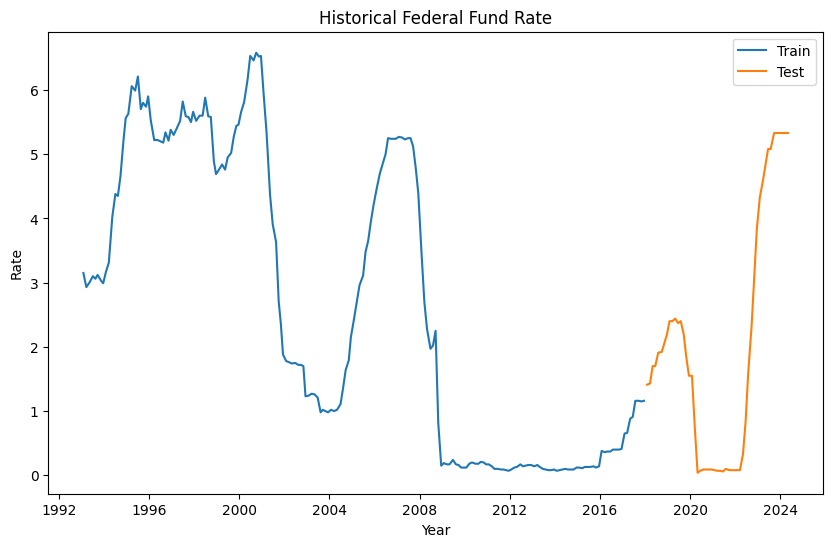

In [22]:
plt.figure(figsize=(10,6))
plt.plot(y.index[:train_size], y_train, label='Train')
plt.plot(y.index[train_size:], y_test, label='Test')
plt.title('Historical Federal Fund Rate')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.legend()


# **Supervising Learning** 

In [23]:
results = {}

A basic model using Linear Regression will be trained on the meeting minutes after applying TF-IDF vectorization. This model will serve as a baseline for comparing other models. The only features used for training are the raw text vectorized into numerical format.

Means squared error is :4.315016653535205
R2 Score is :-23.044729132139004


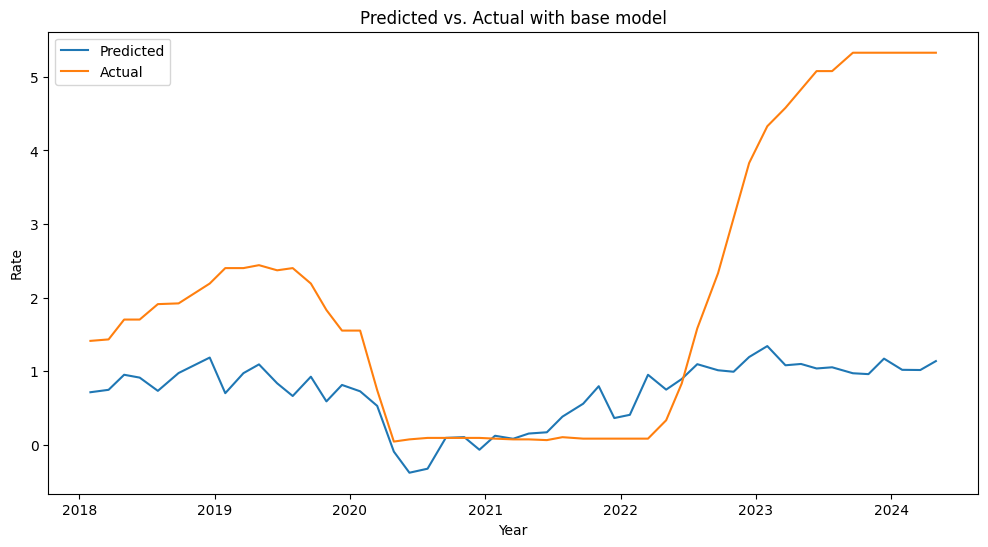

In [24]:
# Perform TF-IDF Vectorizer on the training text corpus
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train.values)
X_test_vectorized = vectorizer.transform(X_test.values)

# Set up model and fit
base_model = LinearRegression()
base_model.fit(X_train_vectorized, y_train)


# Predict, evaluate and plot
y_pred = base_model.predict(X_test_vectorized)
mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)
print(f'Means squared error is :{mse}')
print(f'R2 Score is :{r2}')

# Set up dictionary in results to save information
results['base_model_lr'] = {
    'model': base_model,
    'predicted': y_pred,
    'mse': mse,
    'r2': r2
}
plt.figure(figsize=(12,6))
plt.plot(y.index[train_size:], y_pred, label='Predicted')
plt.plot(y.index[train_size:], y_test, label='Actual')
plt.title('Predicted vs. Actual with base model')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.legend()
plt.show()

Linear Regression:
Best Parameters for lr_basic: {'svd__n_components': 100, 'tfidf__max_features': 500}
Mean Squared Error for lr_basic: 2.9469953218289078
R^2 Score for lr_basic: 0.16939462243384296

Support Vector Machine (SVM):
Best Parameters for svm_basic: {'clf__C': 10, 'svd__n_components': 100, 'tfidf__max_features': 500}
Mean Squared Error for svm_basic: 3.1330614372420382
R^2 Score for svm_basic: 0.11695221952256896

Decision Tree Regressor:
Best Parameters for dt_basic: {'clf__max_depth': 10, 'svd__n_components': 50, 'tfidf__max_features': 500}
Mean Squared Error for dt_basic: 6.594108402777778
R^2 Score for dt_basic: -0.8585376973731706


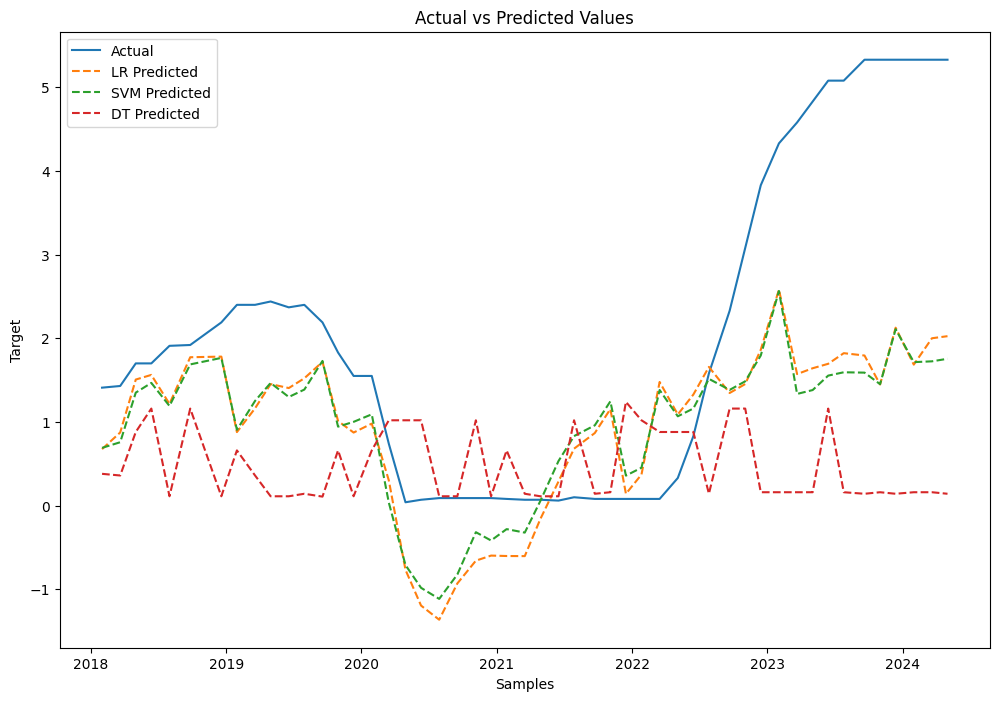

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

# Define pipelines
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', LinearRegression())
])

svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', SVR(kernel='linear'))
])

dt_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', DecisionTreeRegressor(random_state=42))
])

# Define parameter grids for GridSearchCV
param_grid_lr = {
    'tfidf__max_features': [500, 1000],
    'svd__n_components': [50, 100]
}

param_grid_svm = {
    'tfidf__max_features': [500, 1000],
    'svd__n_components': [50, 100],
    'clf__C': [0.1, 1, 10]
}

param_grid_dt = {
    'tfidf__max_features': [500, 1000],
    'svd__n_components': [50, 100],
    'clf__max_depth': [5, 10, 20]
}

# Perform grid search
lr_search = GridSearchCV(lr_pipeline, param_grid_lr, scoring='neg_mean_squared_error', cv=5)
svm_search = GridSearchCV(svm_pipeline, param_grid_svm, scoring='neg_mean_squared_error', cv=5)
dt_search = GridSearchCV(dt_pipeline, param_grid_dt, scoring='neg_mean_squared_error', cv=5)

# Evaluation function
def evaluate_model(search, X_train, X_test, y_train, y_test, model_name):
    search.fit(X_train, y_train)
    predictions = search.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Best Parameters for {model_name}: {search.best_params_}")
    print(f"Mean Squared Error for {model_name}: {mse}")
    print(f"R^2 Score for {model_name}: {r2}")
    
    # Update results dictionary
    results[model_name] = {
        'model': search.best_estimator_,
        'predicted': predictions,
        'mse': mse,
        'r2': r2
    }
    
    return predictions

# Evaluate models
print("Linear Regression:")
lr_predictions = evaluate_model(lr_search, X_train, X_test, y_train, y_test, 'lr_basic')

print("\nSupport Vector Machine (SVM):")
svm_predictions = evaluate_model(svm_search, X_train, X_test, y_train, y_test, 'svm_basic')

print("\nDecision Tree Regressor:")
dt_predictions = evaluate_model(dt_search, X_train, X_test, y_train, y_test, 'dt_basic')

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(y.index[train_size:], y_test, label='Actual', linestyle='solid')
plt.plot(y.index[train_size:], lr_predictions, label='LR Predicted', linestyle='dashed')
plt.plot(y.index[train_size:], svm_predictions, label='SVM Predicted', linestyle='dashed')
plt.plot(y.index[train_size:], dt_predictions, label='DT Predicted', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Target')
plt.show()

### Add Engineered Features

In [80]:
data

,meeting_minute,rate
file_date,,
1993-02-03,frb fomc minutesfebruary 23 1993 minutes feder...,3.15
1993-03-23,frb fomc minutesmarch 23 1993 minutes federal ...,2.93
1993-05-18,frb fomc minutesmay 18 1993 minutes federal op...,3.01
1993-07-07,frb fomc minutesjuly 67 1993 minutes federal o...,3.10
1993-08-17,frb fomc minutesaugust 17 1993 minutes federal...,3.06
...,...,...
2023-11-01,fed monetary policy skip main content back hom...,5.33
2023-12-13,fed monetary policy skip main content back hom...,5.33
2024-01-31,fed monetary policy skip main content back hom...,5.33


In [86]:
    data = merge_df.copy()

    if 'file_date' not in data.columns:
        data.reset_index(inplace=True)

    data.drop(columns=['diff', 'changed'], inplace=True)
    data['file_date'] = pd.to_datetime(data['file_date'])

    data['year'] = data['file_date'].dt.year
    data['month'] = data['file_date'].dt.month
    data['day'] = data['file_date'].dt.day

    lags = [1, 3, 6, 12]
    windows = [6, 12, 18, 24]

    for lag in lags:
        data[f'rate_{lag}'] = data['rate'].shift(lag)

    for window in windows:
        data[f'rate_rolling_mean_{window}'] = data['rate'].rolling(window=window).mean()
        data[f'rate_rolling_std_{window}'] = data['rate'].rolling(window=window).std()

    data.fillna(method='bfill', inplace=True)
    data.set_index(['file_date'], inplace=True)


    X_train, y_train = data.drop(columns=['rate'])[:train_size], data['rate'][:train_size]
    X_test, y_test = data.drop(columns=['rate'])[train_size:], data['rate'][train_size:]

    X_train.head()

,meeting_minute,year,month,day,rate_1,rate_3,rate_6,rate_12,rate_rolling_mean_6,rate_rolling_std_6,rate_rolling_mean_12,rate_rolling_std_12,rate_rolling_mean_18,rate_rolling_std_18,rate_rolling_mean_24,rate_rolling_std_24
file_date,,,,,,,,,,,,,,,,
1993-02-03,frb fomc minutesfebruary 23 1993 minutes feder...,1993,2,3,3.15,3.15,3.15,3.15,3.061667,0.08085,3.2725,0.45078,3.930556,1.081396,4.420417,1.274101
1993-03-23,frb fomc minutesmarch 23 1993 minutes federal ...,1993,3,23,3.15,3.15,3.15,3.15,3.061667,0.08085,3.2725,0.45078,3.930556,1.081396,4.420417,1.274101
1993-05-18,frb fomc minutesmay 18 1993 minutes federal op...,1993,5,18,2.93,3.15,3.15,3.15,3.061667,0.08085,3.2725,0.45078,3.930556,1.081396,4.420417,1.274101
1993-07-07,frb fomc minutesjuly 67 1993 minutes federal o...,1993,7,7,3.01,3.15,3.15,3.15,3.061667,0.08085,3.2725,0.45078,3.930556,1.081396,4.420417,1.274101
1993-08-17,frb fomc minutesaugust 17 1993 minutes federal...,1993,8,17,3.10,2.93,3.15,3.15,3.061667,0.08085,3.2725,0.45078,3.930556,1.081396,4.420417,1.274101


In [90]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('svd', TruncatedSVD(n_components=100))
])

# Define temporal features (excluding 'rate')
temporal_features = ['year', 'month', 'day'] + \
                    [f'rate_{lag}' for lag in lags] + \
                    [f'rate_rolling_mean_{window}' for window in windows] + \
                    [f'rate_rolling_std_{window}' for window in windows]

# Define the preprocessor for both text and temporal features
preprocessor = ColumnTransformer(
    transformers=[
        ('meeting_minute', text_transformer, 'meeting_minute'),
        ('temporal', StandardScaler(), temporal_features)
    ])

# Apply the preprocessor to the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

Linear Regression:
Best Parameters for lr: {}
Mean Squared Error for lr: 0.8286032215129233
R^2 Score for lr: 0.718412044277553

Support Vector Machine (SVM):
Best Parameters for svm: {'clf__C': 1}
Mean Squared Error for svm: 0.19754246307215156
R^2 Score for svm: 0.9328682572060256

Decision Tree Regressor:
Best Parameters for dt: {'clf__max_depth': 5}
Mean Squared Error for dt: 1.1115773671285638
R^2 Score for dt: 0.622247668956003

XGBoost Regressor:
Best Parameters for xgb: {'clf__learning_rate': 0.2, 'clf__max_depth': 7, 'clf__n_estimators': 200}
Mean Squared Error for xgb: 0.45529242360049665
R^2 Score for xgb: 0.8452759300362161


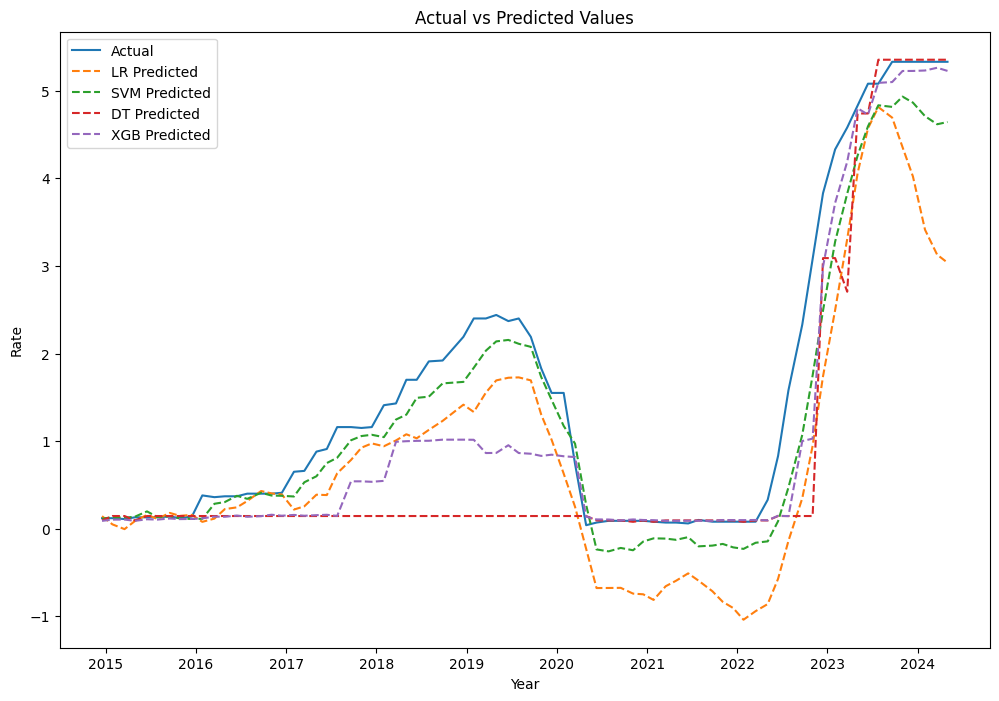

In [94]:
from xgboost import XGBRegressor


# Define pipelines for each model
lr_pipeline = Pipeline([
    ('clf', LinearRegression())
])

svm_pipeline = Pipeline([
    ('clf', SVR(kernel='linear'))
])

dt_pipeline = Pipeline([
    ('clf', DecisionTreeRegressor(random_state=42))
])

xgb_pipeline = Pipeline([
    ('clf', XGBRegressor(random_state=42))
])

# Define parameter grids for GridSearchCV
param_grid_lr = {}

param_grid_svm = {
    'clf__C': [0.1, 1, 10]
}

param_grid_dt = {
    'clf__max_depth': [5, 10, 20]
}

param_grid_xgb = {
    'clf__n_estimators': [100, 200, 300],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [3, 5, 7]
}

# Perform grid search
lr_search = GridSearchCV(lr_pipeline, param_grid_lr, scoring='neg_mean_squared_error', cv=5)
svm_search = GridSearchCV(svm_pipeline, param_grid_svm, scoring='neg_mean_squared_error', cv=5)
dt_search = GridSearchCV(dt_pipeline, param_grid_dt, scoring='neg_mean_squared_error', cv=5)
xgb_search = GridSearchCV(xgb_pipeline, param_grid_xgb, scoring='neg_mean_squared_error', cv=5)

# Evaluation function
def evaluate_model(search, X_train_final, X_test_final, y_train, y_test, model_name):
    search.fit(X_train_final, y_train)
    predictions = search.predict(X_test_final)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Best Parameters for {model_name}: {search.best_params_}")
    print(f"Mean Squared Error for {model_name}: {mse}")
    print(f"R^2 Score for {model_name}: {r2}")
    
    # Update results dictionary
    results[model_name] = {
        'model': search.best_estimator_,
        'predicted': predictions,
        'mse': mse,
        'r2': r2
    }
    
    return predictions

# Evaluate models
print("Linear Regression:")
lr_predictions = evaluate_model(lr_search, X_train_transformed, X_test_transformed, y_train, y_test, 'lr')

print("\nSupport Vector Machine (SVM):")
svm_predictions = evaluate_model(svm_search, X_train_transformed, X_test_transformed, y_train, y_test, 'svm')

print("\nDecision Tree Regressor:")
dt_predictions = evaluate_model(dt_search, X_train_transformed, X_test_transformed, y_train, y_test, 'dt')

print("\nXGBoost Regressor:")
xgb_predictions = evaluate_model(xgb_search, X_train_transformed, X_test_transformed, y_train, y_test, 'xgb')

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(y_test.index, y_test, label='Actual', linestyle='solid')
plt.plot(y_test.index, lr_predictions, label='LR Predicted', linestyle='dashed')
plt.plot(y_test.index, svm_predictions, label='SVM Predicted', linestyle='dashed')
plt.plot(y_test.index, dt_predictions, label='DT Predicted', linestyle='dashed')
plt.plot(y_test.index, xgb_predictions, label='XGB Predicted', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.show()

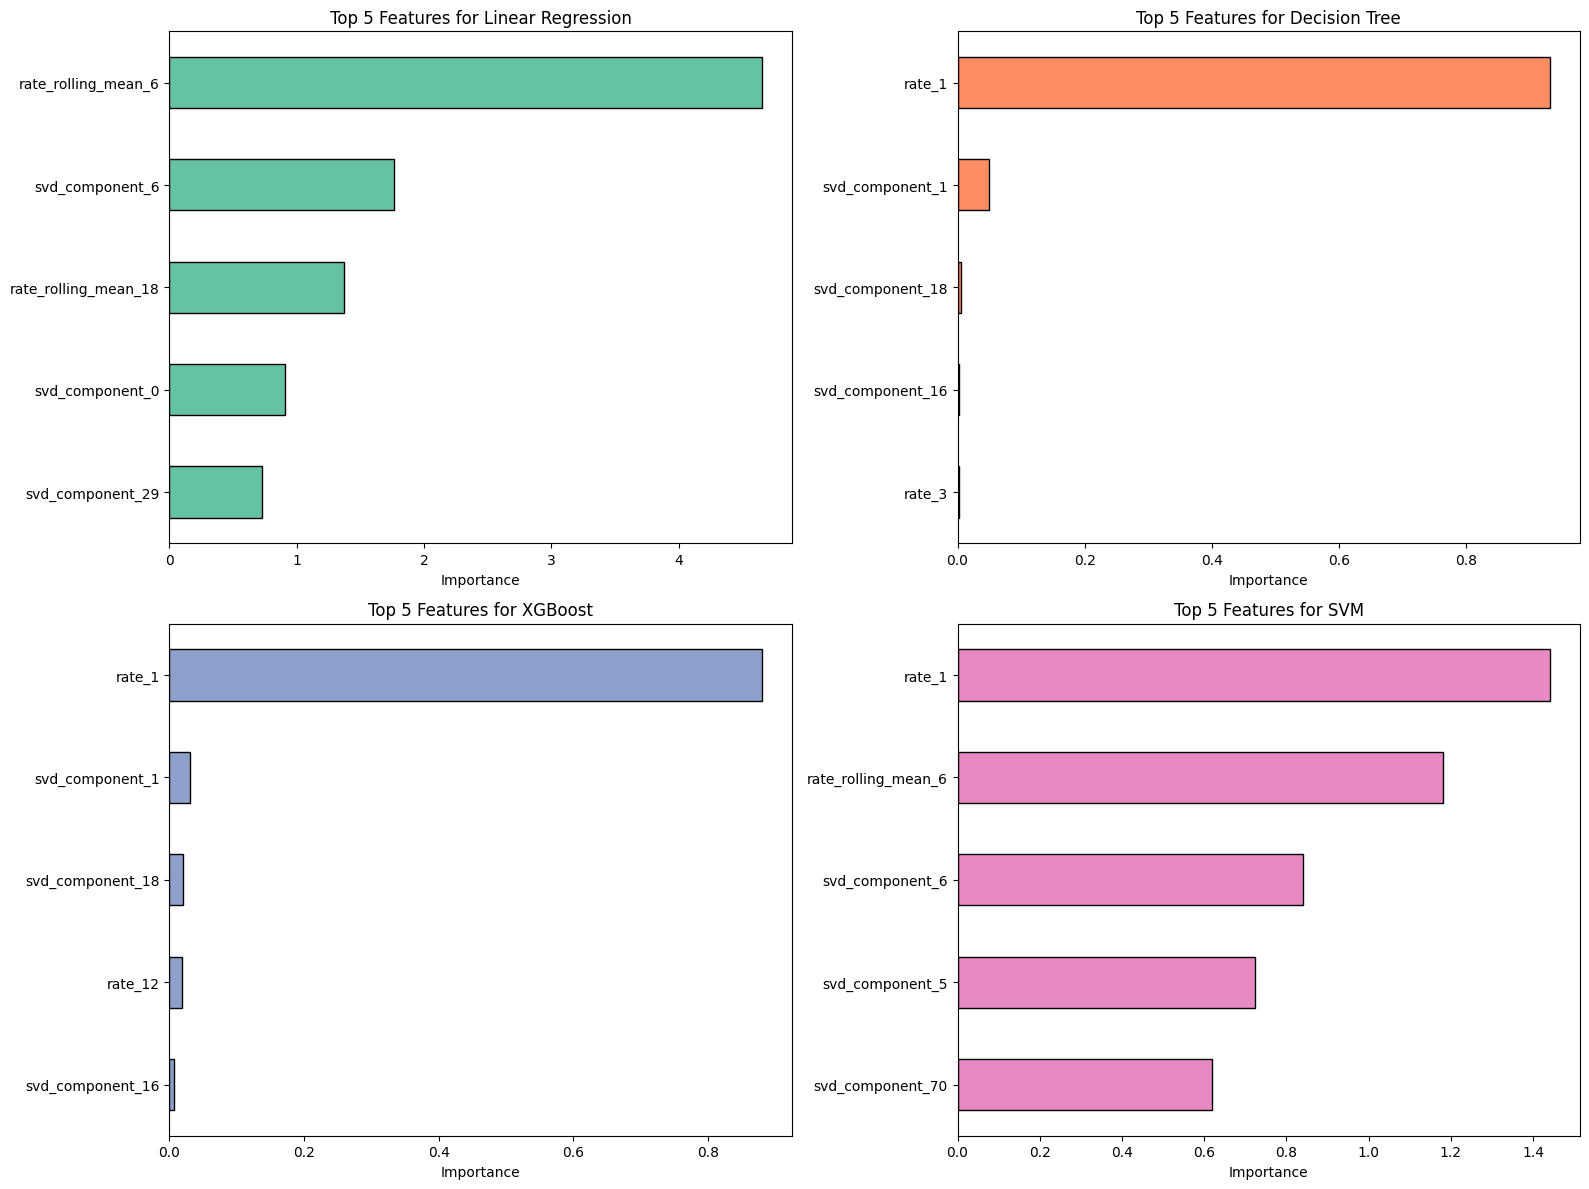

In [108]:
# Function to get top N feature importances
def get_top_feature_importance(model, feature_names, top_n=5):
    if hasattr(model, 'coef_'):
        importance = model.coef_
    elif hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        print(f"No feature importance attribute for {model}")
        return pd.Series()
    
    feature_importance = pd.Series(importance, index=feature_names)
    top_features = feature_importance.sort_values(ascending=False).head(top_n)
    return top_features

# Get feature names from the preprocessor
text_feature_names = [f'svd_component_{i}' for i in range(100)]  # SVD components
temporal_feature_names = temporal_features
all_feature_names = np.concatenate((text_feature_names, temporal_feature_names))

# Extract top 5 features for each model
lr_top_features = get_top_feature_importance(results['lr']['model'].named_steps['clf'], all_feature_names, top_n=5)
dt_top_features = get_top_feature_importance(results['dt']['model'].named_steps['clf'], all_feature_names, top_n=5)
xgb_top_features = get_top_feature_importance(results['xgb']['model'].named_steps['clf'], all_feature_names, top_n=5)

# If you need to plot top 5 for SVM, although it does not provide feature importances directly:
def get_top_svm_coefficients(model, feature_names, top_n=5):
    if hasattr(model, 'coef_'):
        importance = model.coef_.flatten()
    else:
        print(f"No coefficients attribute for {model}")
        return pd.Series()
    
    feature_importance = pd.Series(importance, index=feature_names)
    top_features = feature_importance.sort_values(ascending=False).head(top_n)
    return top_features

svm_top_features = get_top_svm_coefficients(results['svm']['model'].named_steps['clf'], all_feature_names, top_n=5)

# Set a color palette
palette = sns.color_palette("Set2", 4)

# Plotting the top 5 feature importances for each model in a single figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Linear Regression
lr_top_features.plot(kind='barh', ax=axes[0, 0], color=palette[0], edgecolor='black')
axes[0, 0].set_title('Top 5 Features for Linear Regression')
axes[0, 0].set_xlabel('Importance')
axes[0, 0].invert_yaxis()

# Decision Tree
dt_top_features.plot(kind='barh', ax=axes[0, 1], color=palette[1], edgecolor='black')
axes[0, 1].set_title('Top 5 Features for Decision Tree')
axes[0, 1].set_xlabel('Importance')
axes[0, 1].invert_yaxis()

# XGBoost
xgb_top_features.plot(kind='barh', ax=axes[1, 0], color=palette[2], edgecolor='black')
axes[1, 0].set_title('Top 5 Features for XGBoost')
axes[1, 0].set_xlabel('Importance')
axes[1, 0].invert_yaxis()

# SVM
svm_top_features.plot(kind='barh', ax=axes[1, 1], color=palette[3], edgecolor='black')
axes[1, 1].set_title('Top 5 Features for SVM')
axes[1, 1].set_xlabel('Importance')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

## LLM

# **Unsupervising Learning**

In [ ]:
# TODO : David